### Imports

In [85]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [86]:
import pandas as pd
import numpy as np
np.random.seed(42)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score  
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import os
import datetime
from fredapi import Fred
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
import optuna
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, mae, rmse, smape
import random
random.seed(42)


os.environ['OMP_NUM_THREADS'] = '1'
base_dir = Path(os.getcwd()).resolve().parent
base_dir

WindowsPath('C:/Users/diogo/Desktop/ASTP')

In [87]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

## Leitura dos Dados

In [88]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

### Dados Extras

In [89]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [90]:
fred_series_metadata[0]

id                                                                 IHLIDXNSAGB
realtime_start                                                      2025-05-07
realtime_end                                                        2025-05-07
title                             Job Postings on Indeed in the United Kingdom
observation_start                                                   2020-02-01
observation_end                                                     2025-05-02
frequency                                                         Daily, 7-Day
frequency_short                                                              D
units                                                    Index Feb, 1 2020=100
units_short                                              Index Feb, 1 2020=100
seasonal_adjustment                                    Not Seasonally Adjusted
seasonal_adjustment_short                                                  NSA
last_updated                                        

In [91]:
fred_series_list[0].name
fred_series_list[0]

2020-02-01    100.00
2020-02-02     99.90
2020-02-03     99.87
2020-02-04     99.79
2020-02-05     99.73
               ...  
2025-04-28     76.42
2025-04-29     76.55
2025-04-30     76.74
2025-05-01     76.88
2025-05-02     77.05
Name: Job Postings on Indeed in the United Kingdom, Length: 1918, dtype: float64

In [92]:
len(fred_series_list)

5

#### Corrigir Nomes

In [93]:
for i in range(len(fred_series_list)):
    print(fred_series_list[i].name)

Job Postings on Indeed in the United Kingdom
Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
Residential Property Prices for United Kingdom
Gross Domestic Product for United Kingdom
Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom


In [94]:
def gerar_nome_curto(nome_original):
    nome_original = nome_original.lower()
    nome_original = nome_original.replace("united kingdom", "uk")
    nome_original = nome_original.replace("interest rates", "interest_rates")
    nome_original = nome_original.replace("long-term government bond yields", "lt_bond_yields")
    nome_original = nome_original.replace("gross domestic product", "gdp")
    nome_original = nome_original.replace("residential property prices", "house_prices")
    nome_original = nome_original.replace("consumer price index", "cpi")
    nome_original = nome_original.replace("job postings", "job_postings")
    nome_original = nome_original.replace(":", "")
    nome_original = nome_original.replace("(", "")
    nome_original = nome_original.replace(")", "")
    nome_original = nome_original.replace(",", "")
    nome_original = nome_original.replace("-", "_")
    nome_original = nome_original.replace(" ", "_")
    return nome_original.strip("_")


In [95]:
for serie in fred_series_list:
    nome_curto = gerar_nome_curto(serie.name)
    serie.name = nome_curto
    print(serie.name)

job_postings_on_indeed_in_the_uk
interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk
house_prices_for_uk
gdp_for_uk
consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


### Incerteza Politica

In [96]:
UKEPU = pd.read_csv("../data/UK_Daily_Policy_Data.csv")
UKEPU['observation_date'] = pd.to_datetime(UKEPU[['year', 'month', 'day']])
UKEPU.drop(columns=['day', 'month', 'year'], inplace=True)
UKEPU.set_index('observation_date', inplace=True)
UKEPU = UKEPU.squeeze()
UKEPU

observation_date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-03-30    583.59
2025-03-31    246.35
2025-04-01    507.40
2025-04-02    608.20
2025-04-03    417.47
Name: daily_policy_index, Length: 8859, dtype: float64

In [97]:
# Dar nome à série de incerteza política antes de adicionar
UKEPU.name = gerar_nome_curto("UK_Daily_Policy_Data")

# Adicionar à lista de séries
fred_series_list.append(UKEPU)

# Opcional: também adicionar à lista de metadados, com um dicionário simples
fred_series_metadata.append({"id": "UKEPU", "title": "UK_Daily_Policy_Data"})

# Confirmar que foi adicionado
print(f"Nome da série adicionada: {UKEPU.name}")
print(f"Número total de séries: {len(fred_series_list)}")

Nome da série adicionada: uk_daily_policy_data
Número total de séries: 6


## Aplicação dos modelos e comparação dos packages

### Tensorflow - CNN

In [98]:
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Input, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
os.environ['PYTHONHASHSEED'] = '42'

from tensorflow.keras.regularizers import l2

In [99]:
# Funções auxiliares corrigidas
def criar_janelas(serie, seq_length):
    X, y = [], []
    for i in range(len(serie) - seq_length):
        X.append(serie[i:i+seq_length])
        y.append(serie[i+seq_length])
    return np.array(X), np.array(y)

def preparar_dados(serie, seq_length=30):
    # Verificação robusta da série
    if not hasattr(serie, 'index') or not isinstance(serie.index, pd.DatetimeIndex):
        raise ValueError("❌ A série deve ter um índice datetime.")
    
    serie = serie.dropna()
    if len(serie) < seq_length + 10:
        raise ValueError(f"❌ Série muito curta: {len(serie)} pontos. Mínimo necessário: {seq_length + 10}")
    
    # Verificação de outliers
    q1, q3 = np.percentile(serie, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    if any(serie < lower_bound) or any(serie > upper_bound):
        print("⚠️ Aviso: Valores extremos detectados. Considere tratamento adicional.")
    
    scaler = MinMaxScaler()
    serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1)).flatten()

    X, y = criar_janelas(serie_scaled, seq_length)
    split_idx = int(0.8 * len(X))

    X_train = X[:split_idx][..., np.newaxis]
    X_test  = X[split_idx:][..., np.newaxis]
    y_train = y[:split_idx]
    y_test  = y[split_idx:]

    return X_train, X_test, y_train, y_test, scaler, serie_scaled

def visualizar_conjunto_teste(model, serie, X_test, y_test, scaler, seq_length):
    y_pred = model.predict(X_test, verbose=0)

    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    datas_validas = serie.index[-len(y_test):]  # Garante alinhamento correto

    plt.figure(figsize=(14, 6))
    plt.plot(datas_validas, y_test_inv, label="Real", alpha=0.6)
    plt.plot(datas_validas, y_pred_inv, label="Previsão", linestyle="dashed", alpha=0.9)
    plt.title("Previsão do Conjunto de Teste")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def avaliar_modelo(model, X_test, y_test, scaler, serie_scaled, y_train, serie, seq_length=30):
    y_pred = model.predict(X_test, verbose=0)

    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Métricas robustas
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    
    print(f"✅ MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    print(f"✅ MAPE: {mape:.2%} | R²: {r2:.4f}")

    # Preparação das datas para plot
    datas_validas = serie.index[seq_length:]
    y_pred_full = np.concatenate([scaler.inverse_transform(y_train.reshape(-1, 1)), 
                                 y_pred_inv])
    serie_real = scaler.inverse_transform(serie_scaled[seq_length:].reshape(-1, 1))

    plt.figure(figsize=(14, 6))
    plt.plot(datas_validas, serie_real, label="Real", alpha=0.6)
    plt.plot(datas_validas, y_pred_full, label="Previsão", linestyle="dashed", alpha=0.9)
    plt.axvline(datas_validas[len(y_train)], color="red", linestyle="--", 
               label="Início do Teste")
    plt.title(f"Previsão da Série Temporal Completa (CNN): {serie.name}")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def criar_modelo(seq_length):
    model = Sequential([        
        Input(shape=(seq_length, 1)),
        Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),
        
        Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),

        Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),

        GlobalMaxPooling1D(),
        Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.5),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001, clipvalue=0.5)  # Adicionado clipvalue para estabilidade
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse', 'mape'])
    return model

def treinar_para_serie(serie, seq_length=30):
    nome_serie = serie.name.replace(" ", "_").replace("/", "_")
    print(f"\n🔄 Treinando modelo para: {nome_serie}")

    try:
        X_train, X_test, y_train, y_test, scaler, serie_scaled = preparar_dados(serie, seq_length)
        
        model = criar_modelo(seq_length)
        checkpoint_path = f"modelos/best_model_{nome_serie}.h5"
        
        # Garantir que o diretório existe
        try:
            os.makedirs("modelos", exist_ok=True)
        except PermissionError:
            raise PermissionError("Sem permissão para criar diretório 'modelos'")
        
        callbacks = [
            ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=8, min_lr=1e-6, verbose=1),
            EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
            ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1),
            TensorBoard(log_dir=f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}_{nome_serie}")
        ]

        history = model.fit(
            X_train, y_train,
            epochs=150, 
            batch_size=16,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )

        model.load_weights(checkpoint_path)
        visualizar_conjunto_teste(model, serie, X_test, y_test, scaler, seq_length)
        avaliar_modelo(model, X_test, y_test, scaler, serie_scaled, y_train, serie, seq_length)

        # Plot de métricas de treino
        plt.figure(figsize=(15, 10))
        metrics = ['loss', 'mae', 'mse', 'mape']
        titles = ['Loss', 'MAE', 'MSE', 'MAPE']
        
        for i, metric in enumerate(metrics, 1):
            plt.subplot(2, 2, i)
            plt.plot(history.history[metric], label=f"Treino {titles[i-1]}")
            plt.plot(history.history[f'val_{metric}'], label=f"Validação {titles[i-1]}")
            plt.xlabel("Épocas")
            plt.ylabel(titles[i-1])
            plt.legend()
            plt.title(f"Evolução do {titles[i-1]} - {nome_serie}")
            plt.grid(True, linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return model, history
        
    except Exception as e:
        print(f"❌ Erro durante o treino: {str(e)}")
        raise


🚀 Processando série 1/6: job_postings_on_indeed_in_the_uk

🔄 Treinando modelo para: job_postings_on_indeed_in_the_uk
Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9308 - mae: 1.7677 - mape: 786438.0000 - mse: 6.9147
Epoch 1: val_loss improved from inf to 0.16641, saving model to modelos/best_model_job_postings_on_indeed_in_the_uk.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.8938 - mae: 1.7610 - mape: 790717.3125 - mse: 6.8778 - val_loss: 0.1664 - val_mae: 0.3820 - val_mape: 96.4725 - val_mse: 0.1504 - learning_rate: 0.0010
Epoch 2/150
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2590 - mae: 0.3798 - mape: 125373.6641 - mse: 0.2430
Epoch 2: val_loss improved from 0.16641 to 0.13556, saving model to modelos/best_model_job_postings_on_indeed_in_the_uk.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2525 - mae: 0.3745 - mape: 134273.5781 - mse: 0.2366 - val_loss: 0.1356 - val_mae: 0.3388 - val_mape: 85.1873 - val_mse: 0.1197 - learning_rate: 0.0010
Epoch 3/150
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1184 - mae: 0.2521 - mape: 90640.0781 - mse: 0.1026
Epoch 3: val_loss improved from 0.13556 to 0.06570, saving model to modelos/best_model_job_postings_on_indeed_in_the_uk.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1180 - mae: 0.2515 - mape: 97100.2188 - mse: 0.1022 - val_loss: 0.0657 - val_mae: 0.2069 - val_mape: 50.4575 - val_mse: 0.0500 - learning_rate: 0.0010
Epoch 4/150
84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1054 - mae: 0.2307 - mape: 213107.5156 - mse: 0.0897
Epoch 4: val_loss improved from 0.06570 to 0.02848, saving model to modelos/best_model_job_postings_on_indeed_in_the_uk.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1049 - mae: 0.2303 - mape: 232789.3281 - mse: 0.0892 - val_loss: 0.0285 - val_mae: 0.0907 - val_mape: 21.2983 - val_mse: 0.0129 - learning_rate: 0.0010
Epoch 5/150
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0857 - mae: 0.2101 - mape: 76883.2891 - mse: 0.0701
Epoch 5: val_loss improved from 0.02848 to 0.02384, saving model to modelos/best_model_job_postings_on_indeed_in_the_uk.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0853 - mae: 0.2093 - mape: 82356.9609 - mse: 0.0697 - val_loss: 0.0238 - val_mae: 0.0885 - val_mape: 22.1848 - val_mse: 0.0083 - learning_rate: 0.0010
Epoch 6/150
83/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0758 - mae: 0.1938 - mape: 52422.6680 - mse: 0.0603
Epoch 6: val_loss improved from 0.02384 to 0.02148, saving model to modelos/best_model_job_postings_on_indeed_in_the_uk.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0757 - mae: 0.1937 - mape: 57781.1719 - mse: 0.0602 - val_loss: 0.0215 - val_mae: 0.0713 - val_mape: 17.4130 - val_mse: 0.0061 - learning_rate: 0.0010
Epoch 7/150
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0666 - mae: 0.1790 - mape: 53675.6914 - mse: 0.0513
Epoch 7: val_loss did not improve from 0.02148
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0667 - mae: 0.1793 - mape: 57476.8828 - mse: 0.0513 - val_loss: 0.0261 - val_mae: 0.1001 - val_mape: 25.6364 - val_mse: 0.0108 - learning_rate: 0.0010
Epoch 8/150
88/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0663 - mae: 0.1765 - mape: 149430.5469 - mse: 0.0510
Epoch 8: val_loss did not improve from 0.02148
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0658 - mae: 0.1759 - mape: 157397.8750 - mse: 0.0506 - val_loss: 0.0230 - val_mae: 0.0717 - val_mape: 16.8060 - val_mse: 0.0079 - learning_rate: 0.0010
Epoch 9/150
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0544 - mae: 0.158

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0543 - mae: 0.1583 - mape: 36730.6797 - mse: 0.0392 - val_loss: 0.0212 - val_mae: 0.0621 - val_mape: 14.4135 - val_mse: 0.0062 - learning_rate: 0.0010
Epoch 10/150
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0516 - mae: 0.1499 - mape: 58462.8438 - mse: 0.0367
Epoch 10: val_loss did not improve from 0.02119
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0515 - mae: 0.1498 - mape: 63170.9336 - mse: 0.0365 - val_loss: 0.0253 - val_mae: 0.0886 - val_mape: 22.1855 - val_mse: 0.0105 - learning_rate: 0.0010
Epoch 11/150
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0492 - mae: 0.1457 - mape: 143326.1094 - mse: 0.0344
Epoch 11: val_loss improved from 0.02119 to 0.01869, saving model to modelos/best_model_job_postings_on_indeed_in_the_uk.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0491 - mae: 0.1457 - mape: 153573.5938 - mse: 0.0343 - val_loss: 0.0187 - val_mae: 0.0599 - val_mape: 16.0959 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 12/150
84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491 - mae: 0.1498 - mape: 28246.8555 - mse: 0.0345
Epoch 12: val_loss did not improve from 0.01869
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0488 - mae: 0.1491 - mape: 30810.9980 - mse: 0.0342 - val_loss: 0.0203 - val_mae: 0.0651 - val_mape: 15.4457 - val_mse: 0.0058 - learning_rate: 0.0010
Epoch 13/150
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0466 - mae: 0.1437 - mape: 88046.1094 - mse: 0.0321
Epoch 13: val_loss did not improve from 0.01869
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0465 - mae: 0.1435 - mape: 91988.5156 - mse: 0.0320 - val_loss: 0.0230 - val_mae: 0.0673 - val_mape: 15.5519 - val_mse: 0.0086 - learning_rate: 0.0010
Epoch 14/150
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0435 - mae: 0

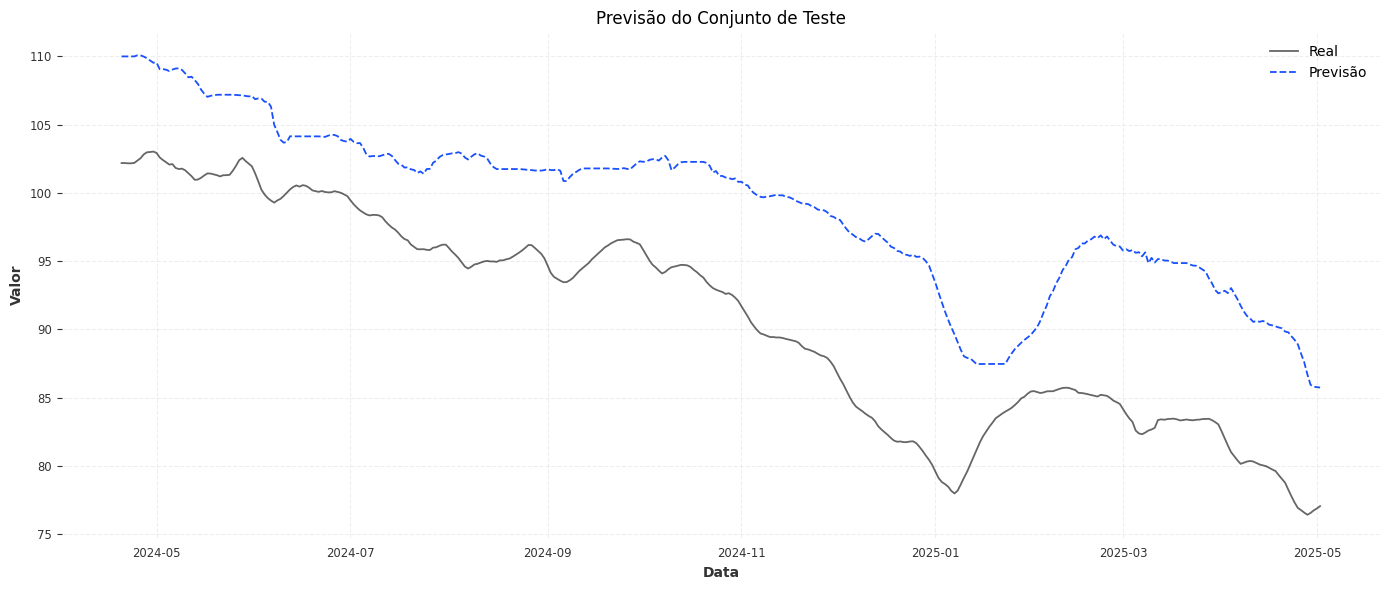

✅ MSE: 77.6922 | MAE: 8.3045 | RMSE: 8.8143
✅ MAPE: 9.42% | R²: -0.2962


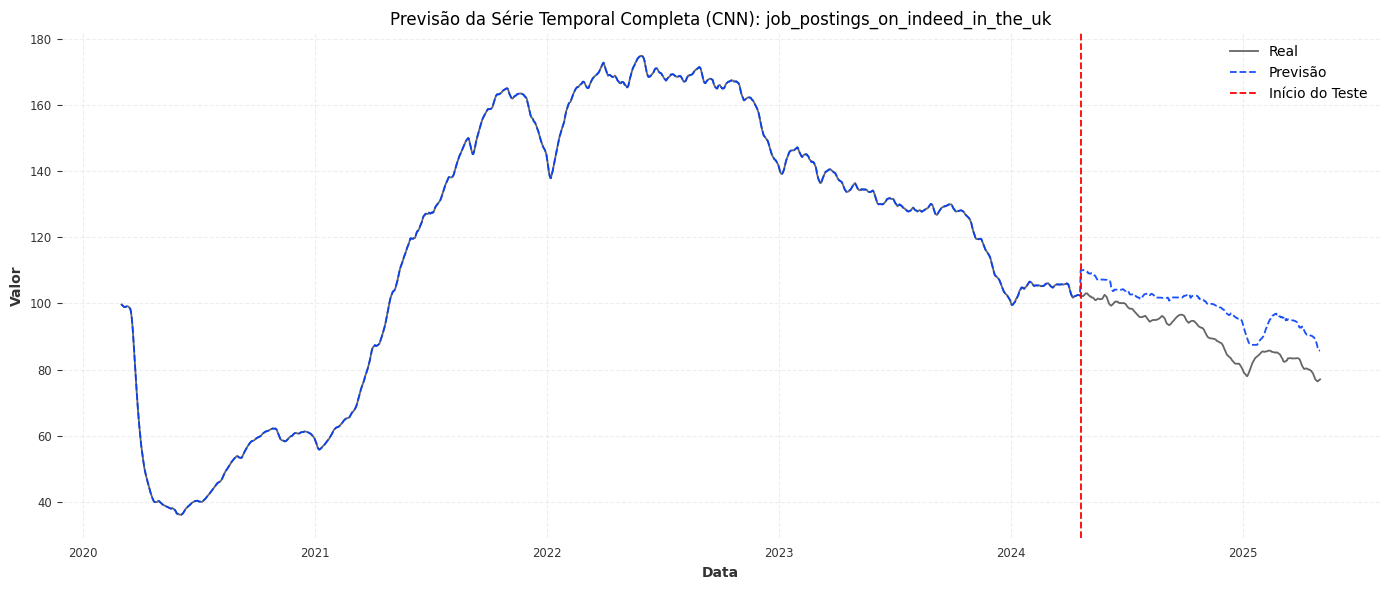

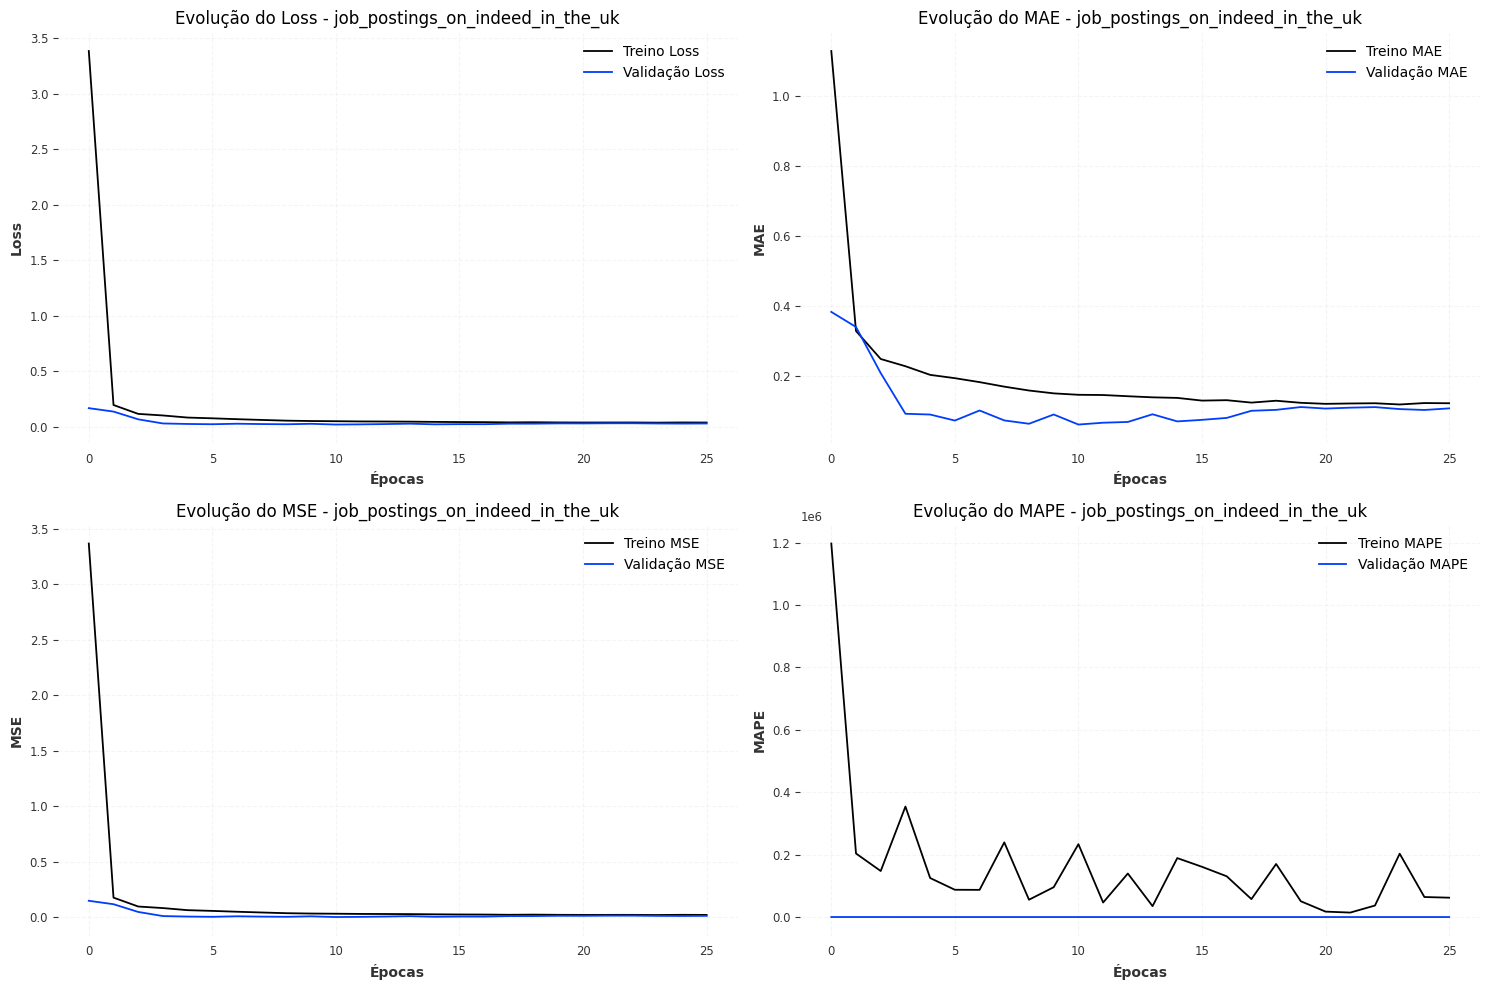


🚀 Processando série 2/6: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk

🔄 Treinando modelo para: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk
Epoch 1/150
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.8299 - mae: 2.7355 - mape: 660.5362 - mse: 15.8138
Epoch 1: val_loss improved from inf to 0.02413, saving model to modelos/best_model_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 15.0674 - mae: 2.6485 - mape: 639.2719 - mse: 15.0513 - val_loss: 0.0241 - val_mae: 0.0682 - val_mape: 605478.2500 - val_mse: 0.0081 - learning_rate: 0.0010
Epoch 2/150
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1281 - mae: 1.1729 - mape: 277.8446 - mse: 3.1120
Epoch 2: val_loss did not improve from 0.02413
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9765 - mae: 1.1415 - mape: 269.9438 - mse: 2.9604 - val_loss: 0.0273 - val_mae: 0.0948 - val_mape: 1199687.2500 - val_mse: 0.0112 - learning_rate: 0.0010
Epoch 3/150
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7510 - mae: 0.6074 - mape: 145.9652 - mse: 0.7349
Epoch 3: val_loss did not improve from 0.02413
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7354 - mae: 0.6003 - mape: 144.4595 - mse: 0.7193 - val_loss: 0.0242 - val_mae: 0.0810 - val_mape: 1067173.2500 - val_mse: 0.0081 - learning_rate: 0.0010
Epoch 4/150
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3117 - mae: 0

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3047 - mae: 0.3991 - mape: 91.6130 - mse: 0.2886 - val_loss: 0.0218 - val_mae: 0.0676 - val_mape: 900158.6250 - val_mse: 0.0057 - learning_rate: 0.0010
Epoch 5/150
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1665 - mae: 0.2927 - mape: 65.5959 - mse: 0.1504
Epoch 5: val_loss did not improve from 0.02182
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1663 - mae: 0.2928 - mape: 65.7128 - mse: 0.1502 - val_loss: 0.0285 - val_mae: 0.1000 - val_mape: 1198226.0000 - val_mse: 0.0124 - learning_rate: 0.0010
Epoch 6/150
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1358 - mae: 0.2704 - mape: 60.3703 - mse: 0.1197
Epoch 6: val_loss did not improve from 0.02182
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1372 - mae: 0.2713 - mape: 60.6053 - mse: 0.1211 - val_loss: 0.0617 - val_mae: 0.2086 - val_mape: 1731073.1250 - val_mse: 0.0456 - learning_rate: 0.0010
Epoch 7/150
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1021 - mae: 0.2278 -

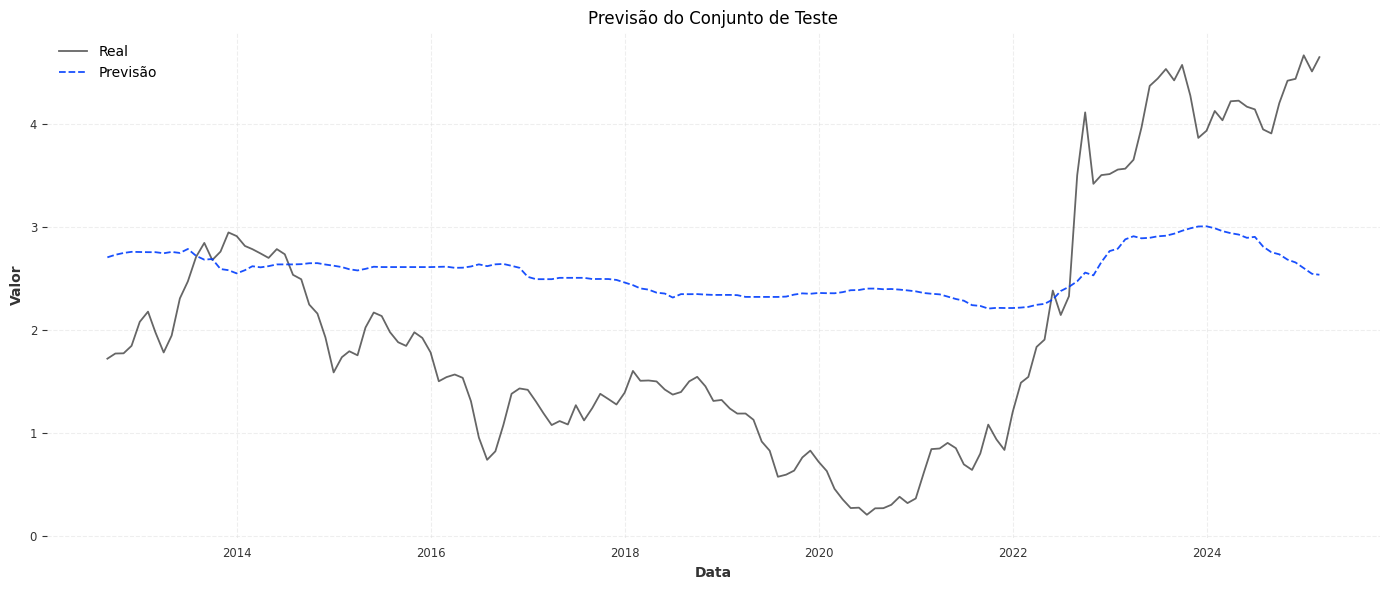

✅ MSE: 1.4867 | MAE: 1.0906 | RMSE: 1.2193
✅ MAPE: 117.18% | R²: 0.0330


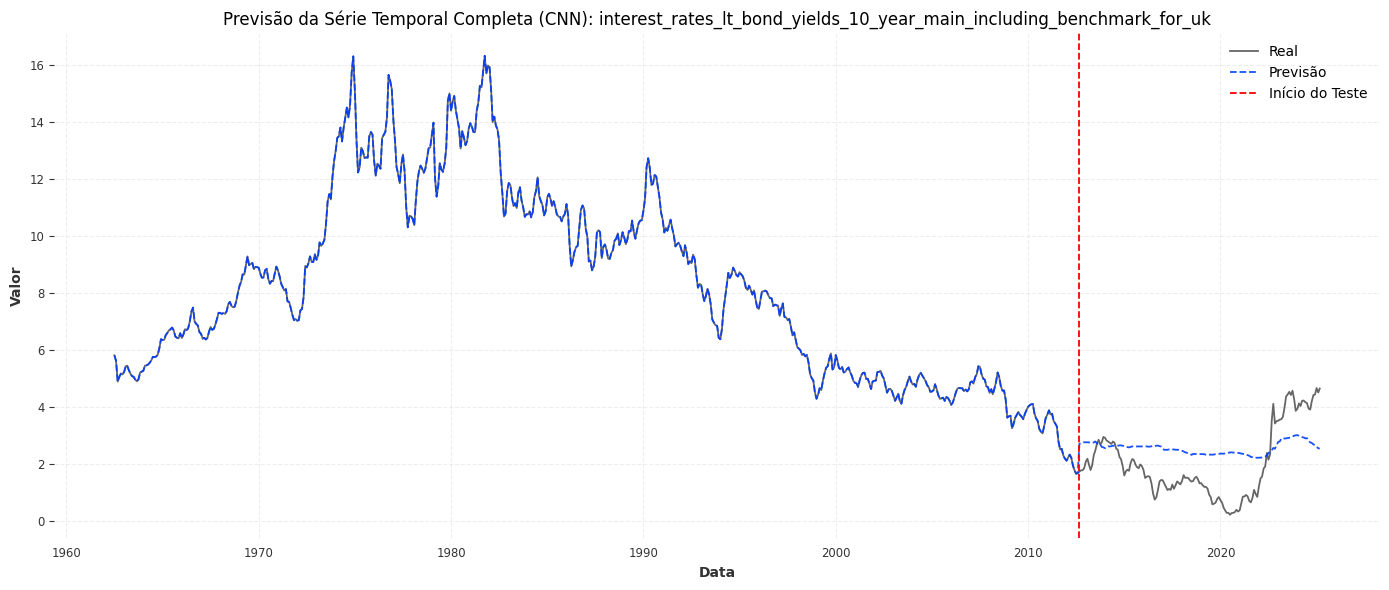

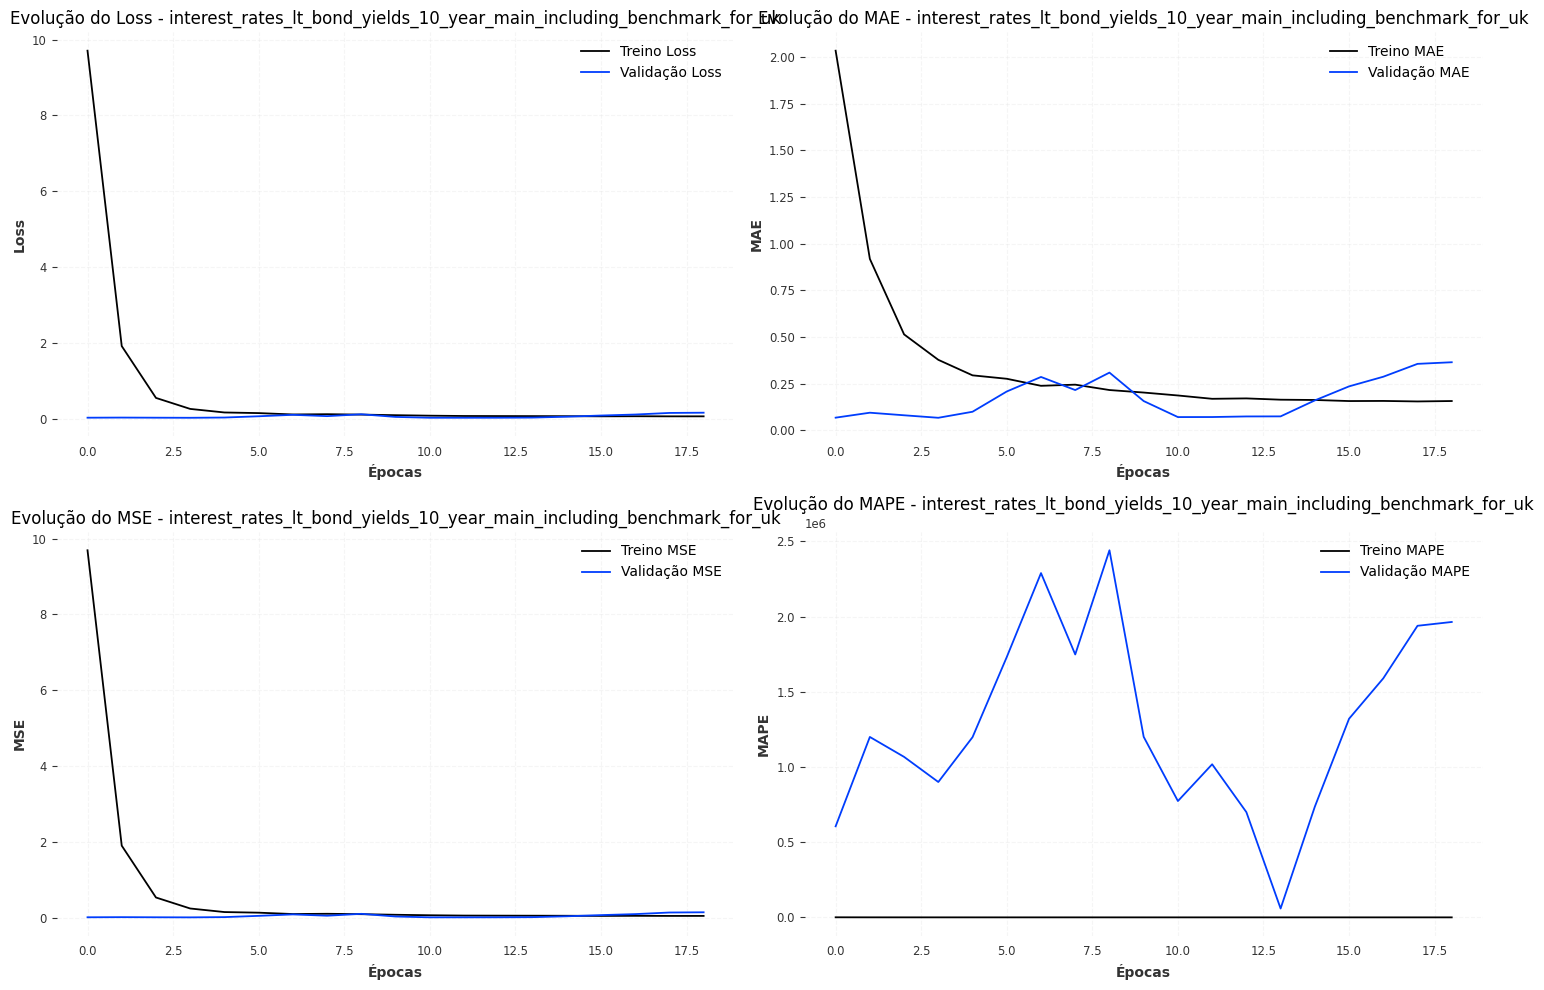


🚀 Processando série 3/6: house_prices_for_uk

🔄 Treinando modelo para: house_prices_for_uk
Epoch 1/150
 1/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 117.7384 - mae: 9.4142 - mape: 6275.4731 - mse: 117.7221
Epoch 1: val_loss improved from inf to 0.65245, saving model to modelos/best_model_house_prices_for_uk.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 71.9317 - mae: 6.6512 - mape: 6877.5054 - mse: 71.9155 - val_loss: 0.6524 - val_mae: 0.7905 - val_mape: 94.7711 - val_mse: 0.6363 - learning_rate: 0.0010
Epoch 2/150
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.3660 - mae: 2.0774 - mape: 2042.6196 - mse: 7.3498
Epoch 2: val_loss improved from 0.65245 to 0.57739, saving model to modelos/best_model_house_prices_for_uk.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.3777 - mae: 2.2940 - mape: 2361.3240 - mse: 10.3615 - val_loss: 0.5774 - val_mae: 0.7422 - val_mape: 88.9598 - val_mse: 0.5612 - learning_rate: 0.0010
Epoch 3/150
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.1661 - mae: 1.8125 - mape: 1434.0355 - mse: 7.1499
Epoch 3: val_loss improved from 0.57739 to 0.53791, saving model to modelos/best_model_house_prices_for_uk.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5321 - mae: 1.7815 - mape: 1852.1621 - mse: 6.5159 - val_loss: 0.5379 - val_mae: 0.7150 - val_mape: 85.6174 - val_mse: 0.5217 - learning_rate: 0.0010
Epoch 4/150
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.6629 - mae: 1.8684 - mape: 1484.1948 - mse: 4.6467
Epoch 4: val_loss improved from 0.53791 to 0.51447, saving model to modelos/best_model_house_prices_for_uk.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5678 - mae: 1.6027 - mape: 1589.3405 - mse: 4.5516 - val_loss: 0.5145 - val_mae: 0.6993 - val_mape: 83.8191 - val_mse: 0.4983 - learning_rate: 0.0010
Epoch 5/150
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.5487 - mae: 1.2867 - mape: 832.2347 - mse: 2.5325
Epoch 5: val_loss did not improve from 0.51447
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8140 - mae: 1.3082 - mape: 1435.7061 - mse: 2.7978 - val_loss: 0.5236 - val_mae: 0.7059 - val_mape: 84.6185 - val_mse: 0.5074 - learning_rate: 0.0010
Epoch 6/150
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.9079 - mae: 1.3910 - mape: 945.9772 - mse: 3.8918
Epoch 6: val_loss did not improve from 0.51447
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9053 - mae: 1.1874 - mape: 1367.0801 - mse: 2.8892 - val_loss: 0.5219 - val_mae: 0.7044 - val_mape: 84.4212 - val_mse: 0.5057 - learning_rate: 0.0010
Epoch 7/150
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4205 - mae: 0.9367 - m

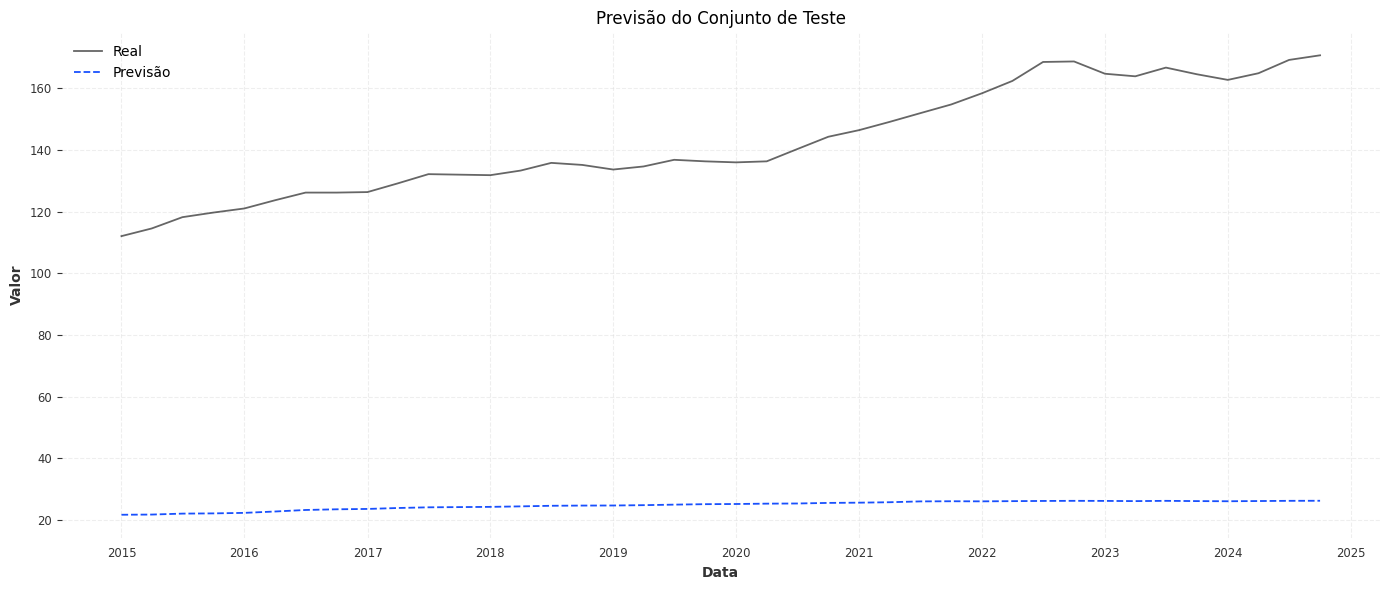

✅ MSE: 14158.3369 | MAE: 117.8855 | RMSE: 118.9888
✅ MAPE: 82.52% | R²: -45.4567


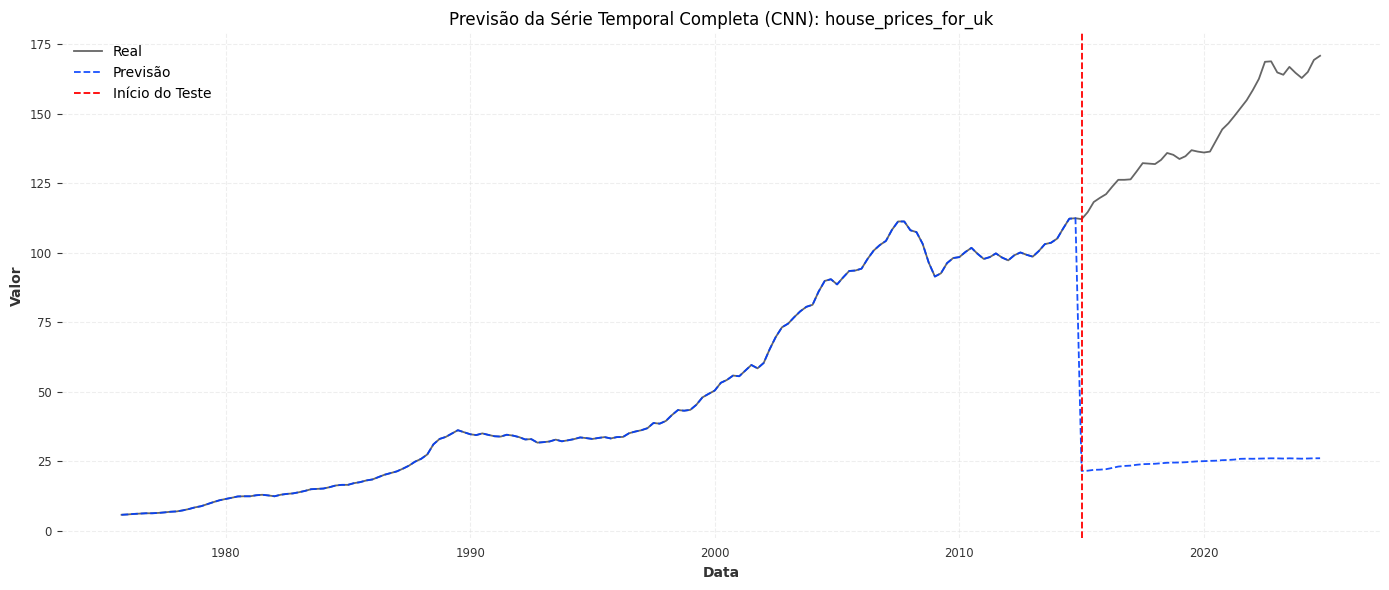

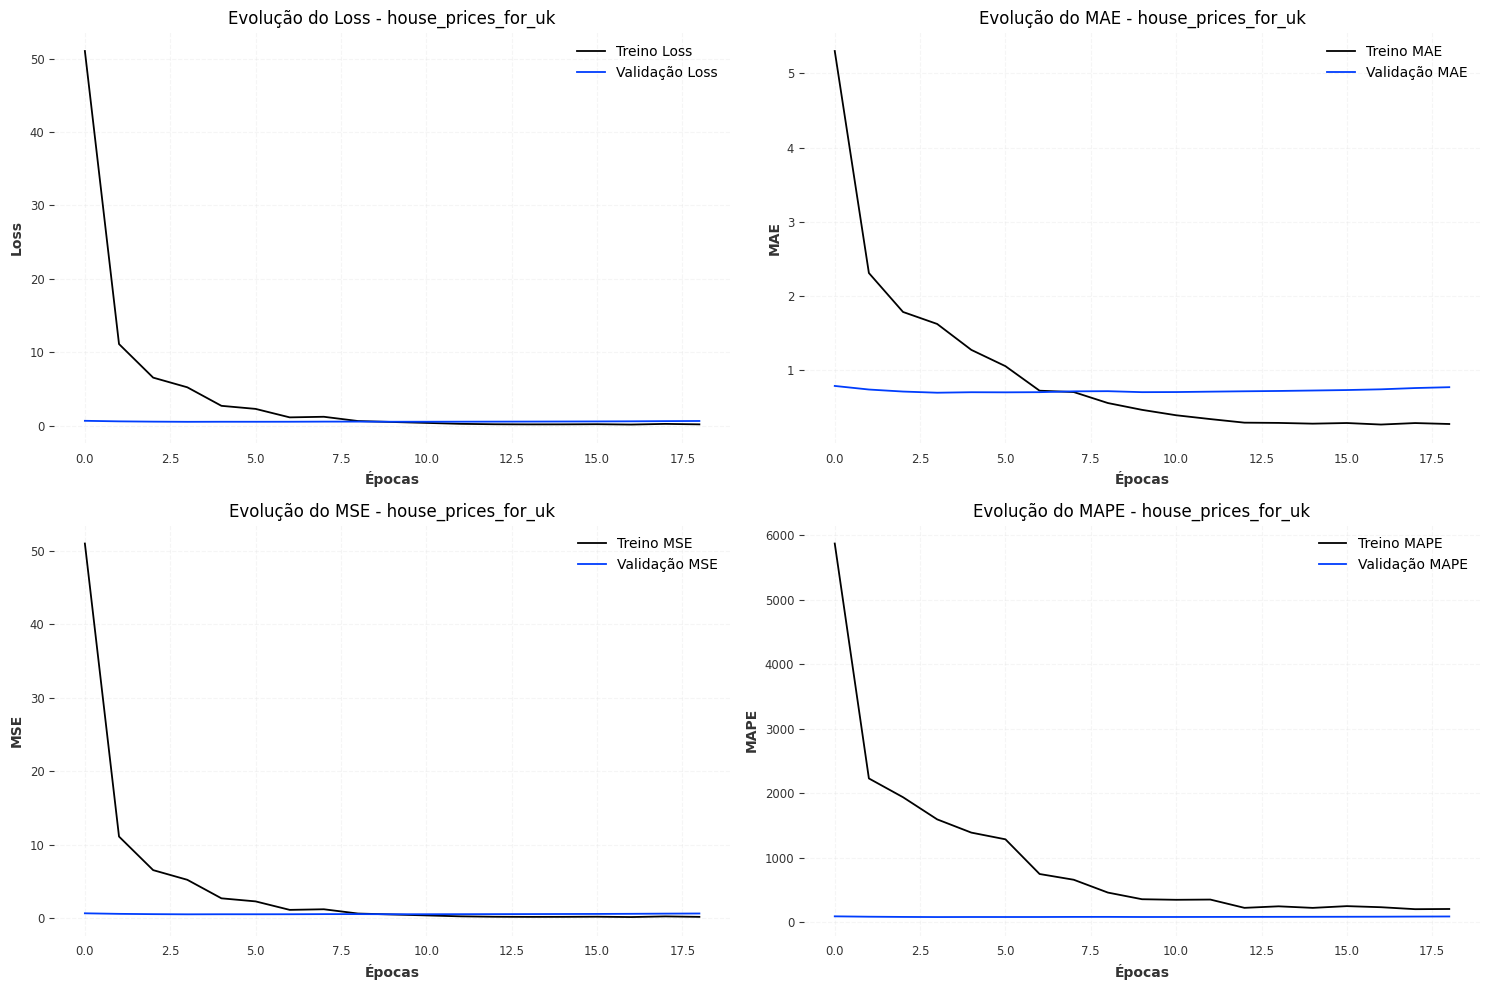


🚀 Processando série 4/6: gdp_for_uk

🔄 Treinando modelo para: gdp_for_uk
Epoch 1/150
 1/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 44.0400 - mae: 5.6371 - mape: 22265.4199 - mse: 44.0237
Epoch 1: val_loss improved from inf to 0.62059, saving model to modelos/best_model_gdp_for_uk.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 16.9571 - mae: 3.1361 - mape: 11014.5068 - mse: 16.9409 - val_loss: 0.6206 - val_mae: 0.7681 - val_mape: 101.8723 - val_mse: 0.6044 - learning_rate: 0.0010
Epoch 2/150
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.0667 - mae: 1.3815 - mape: 4457.4268 - mse: 4.0505
Epoch 2: val_loss did not improve from 0.62059
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2492 - mae: 1.3986 - mape: 4205.8696 - mse: 4.2330 - val_loss: 0.6755 - val_mae: 0.8056 - val_mape: 107.3203 - val_mse: 0.6594 - learning_rate: 0.0010
Epoch 3/150
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.3829 - mae: 0.9066 - mape: 3274.6165 - mse: 1.3668
Epoch 3: val_loss did not improve from 0.62059
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1478 - mae: 0.9677 - mape: 2573.1238 - mse: 2.1316 - val_loss: 0.7688 - val_mae: 0.8617 - val_mape: 114.9404 - val_mse: 0.7527 - learning_rate: 0.0010
Epoch 4/150
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1590 - mae: 0.

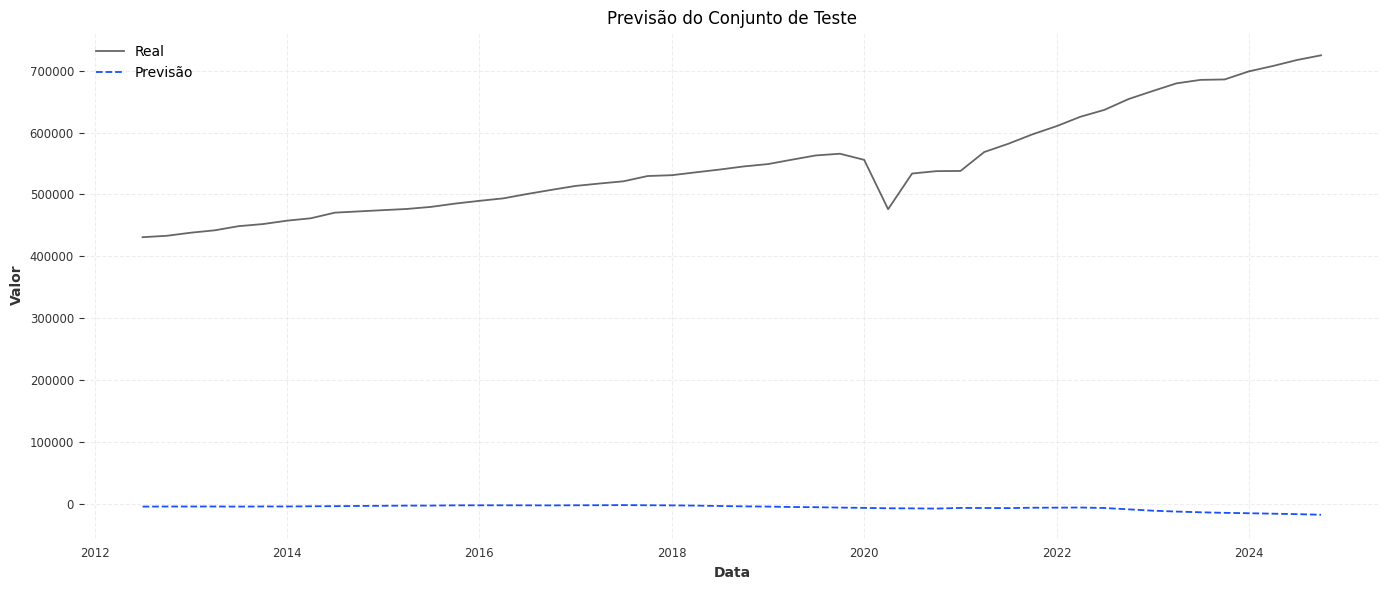

✅ MSE: 313385218520.2245 | MAE: 553051.3263 | RMSE: 559808.1980
✅ MAPE: 100.99% | R²: -44.3261


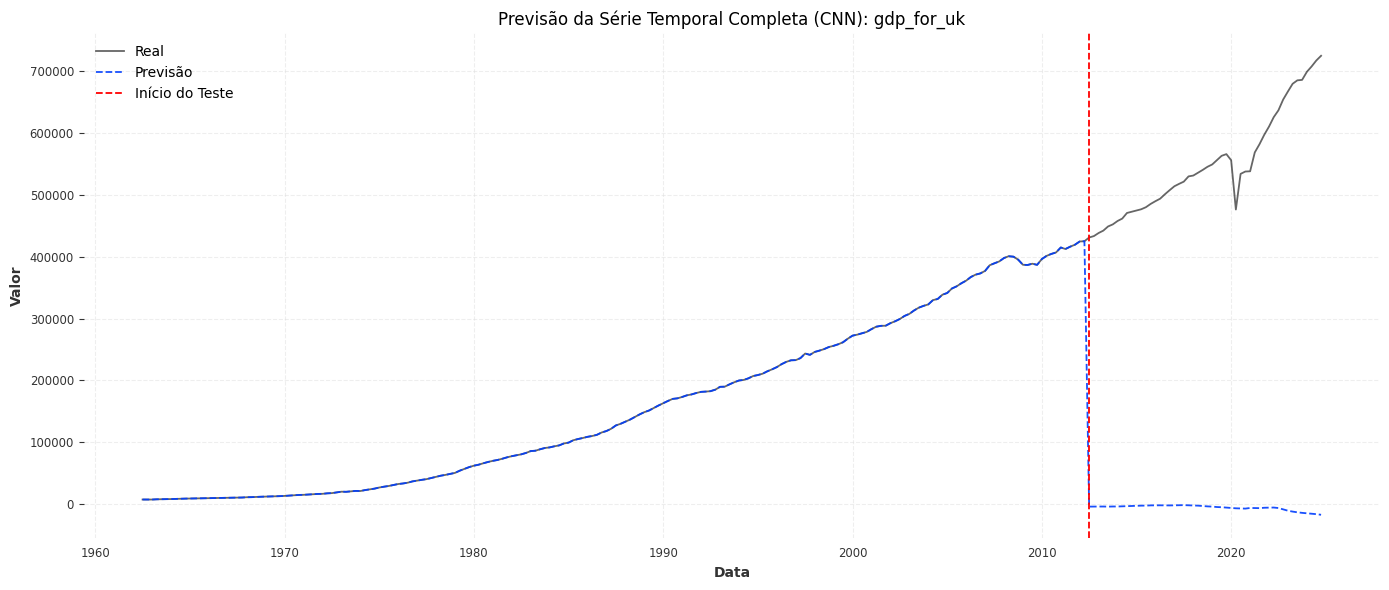

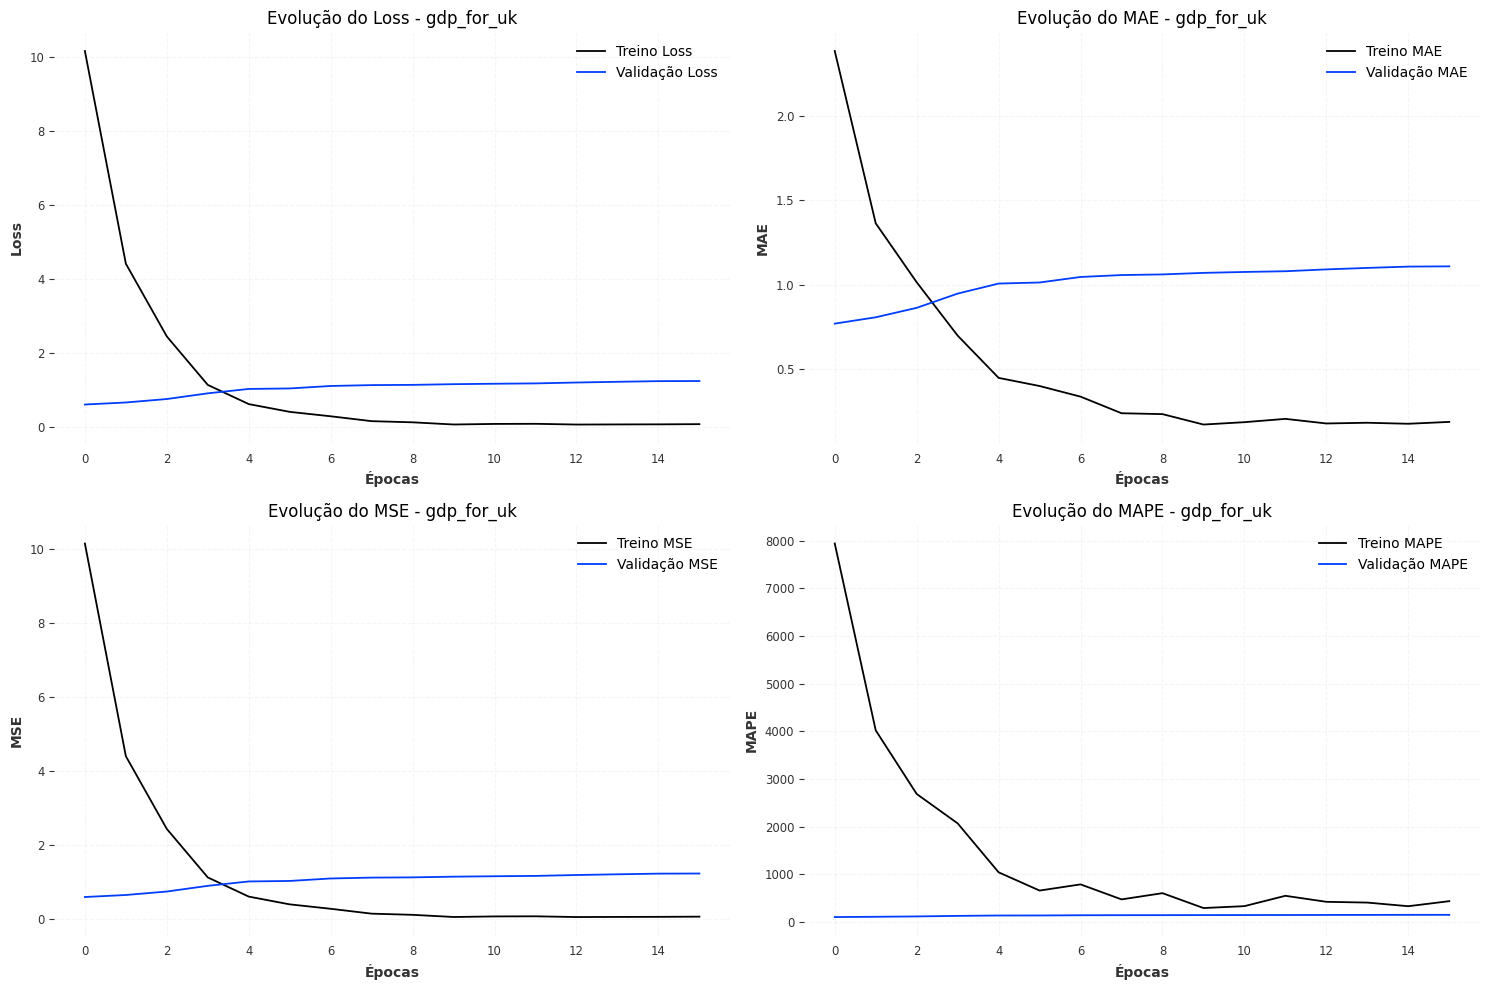


🚀 Processando série 5/6: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk

🔄 Treinando modelo para: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk
Epoch 1/150
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.3678 - mae: 2.7226 - mape: 11110.8584 - mse: 14.3516
Epoch 1: val_loss improved from inf to 0.31331, saving model to modelos/best_model_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 13.5434 - mae: 2.6268 - mape: 10533.3008 - mse: 13.5273 - val_loss: 0.3133 - val_mae: 0.5369 - val_mape: 67.1671 - val_mse: 0.2972 - learning_rate: 0.0010
Epoch 2/150
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6596 - mae: 1.1535 - mape: 3441.3215 - mse: 2.6435
Epoch 2: val_loss improved from 0.31331 to 0.23956, saving model to modelos/best_model_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5050 - mae: 1.1190 - mape: 3347.1404 - mse: 2.4888 - val_loss: 0.2396 - val_mae: 0.4660 - val_mape: 58.3262 - val_mse: 0.2234 - learning_rate: 0.0010
Epoch 3/150
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6506 - mae: 0.5737 - mape: 1638.6069 - mse: 0.6345
Epoch 3: val_loss improved from 0.23956 to 0.21027, saving model to modelos/best_model_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6237 - mae: 0.5628 - mape: 1601.1707 - mse: 0.6075 - val_loss: 0.2103 - val_mae: 0.4319 - val_mape: 53.8863 - val_mse: 0.1942 - learning_rate: 0.0010
Epoch 4/150
31/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2348 - mae: 0.3578 - mape: 1016.1385 - mse: 0.2187
Epoch 4: val_loss improved from 0.21027 to 0.09990, saving model to modelos/best_model_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2269 - mae: 0.3520 - mape: 976.0710 - mse: 0.2108 - val_loss: 0.0999 - val_mae: 0.2749 - val_mape: 33.8342 - val_mse: 0.0838 - learning_rate: 0.0010
Epoch 5/150
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1385 - mae: 0.2711 - mape: 759.5314 - mse: 0.1224
Epoch 5: val_loss improved from 0.09990 to 0.05769, saving model to modelos/best_model_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1338 - mae: 0.2652 - mape: 725.7473 - mse: 0.1178 - val_loss: 0.0577 - val_mae: 0.1750 - val_mape: 20.9256 - val_mse: 0.0417 - learning_rate: 0.0010
Epoch 6/150
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0973 - mae: 0.2167 - mape: 512.9200 - mse: 0.0812
Epoch 6: val_loss improved from 0.05769 to 0.04371, saving model to modelos/best_model_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0950 - mae: 0.2138 - mape: 504.7149 - mse: 0.0790 - val_loss: 0.0437 - val_mae: 0.1176 - val_mape: 13.4589 - val_mse: 0.0277 - learning_rate: 0.0010
Epoch 7/150
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0679 - mae: 0.1755 - mape: 347.3750 - mse: 0.0520
Epoch 7: val_loss did not improve from 0.04371
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0678 - mae: 0.1746 - mape: 342.9291 - mse: 0.0518 - val_loss: 0.0549 - val_mae: 0.1359 - val_mape: 15.4777 - val_mse: 0.0390 - learning_rate: 0.0010
Epoch 8/150
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0720 - mae: 0.1749 - mape: 339.9128 - mse: 0.0560
Epoch 8: val_loss did not improve from 0.04371
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0702 - mae: 0.1724 - mape: 331.3580 - mse: 0.0543 - val_loss: 0.0517 - val_mae: 0.1372 - val_mape: 16.3119 - val_mse: 0.0358 - learning_rate: 0.0010
Epoch 9/150
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0600 - mae: 0.1565 - mape: 27

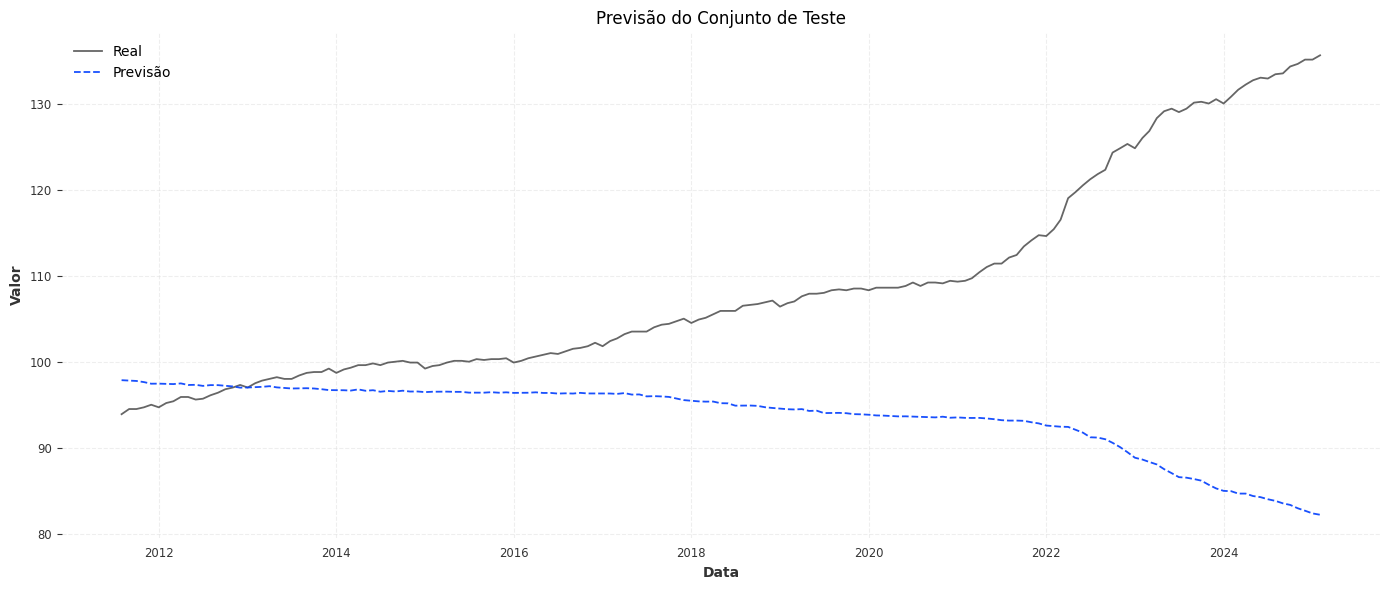

✅ MSE: 474.0248 | MAE: 15.3777 | RMSE: 21.7721
✅ MAPE: 12.90% | R²: -2.4322


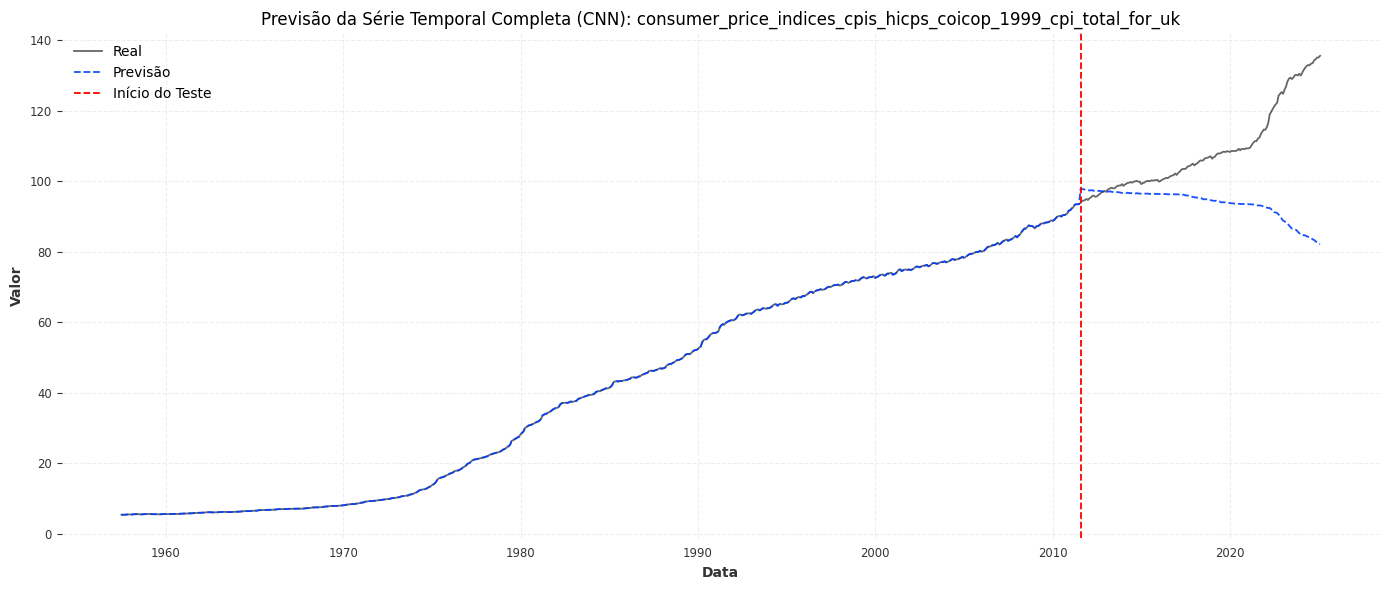

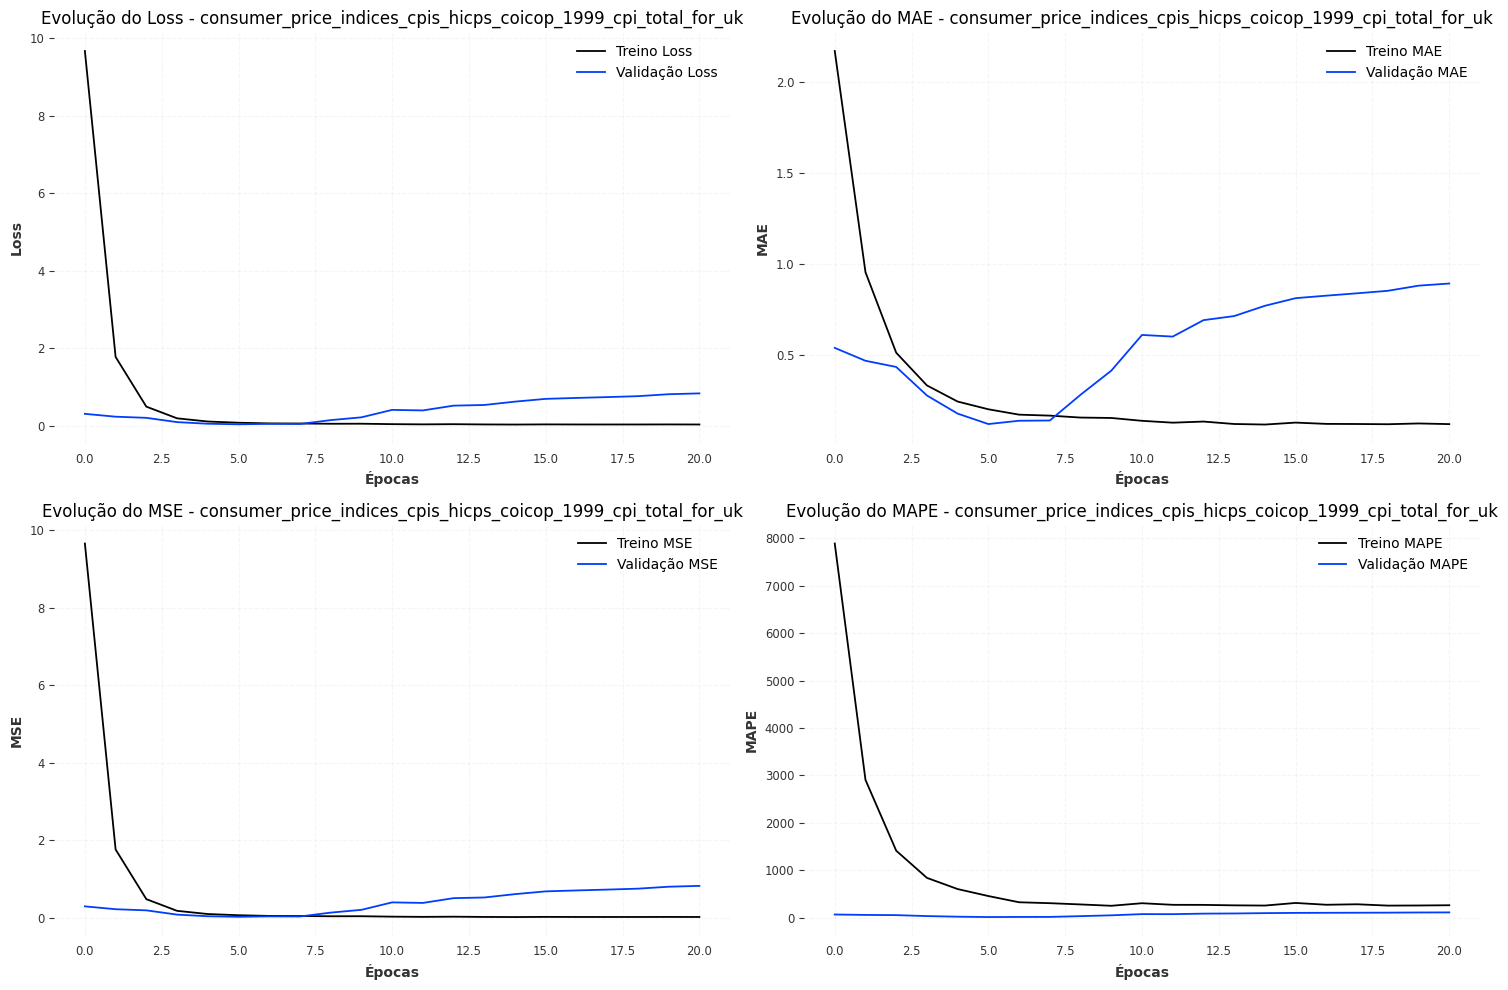


🚀 Processando série 6/6: uk_daily_policy_data

🔄 Treinando modelo para: uk_daily_policy_data
⚠️ Aviso: Valores extremos detectados. Considere tratamento adicional.
Epoch 1/150
440/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0279 - mae: 1.3413 - mape: 7750807.0000 - mse: 8.0118
Epoch 1: val_loss improved from inf to 0.02712, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.9866 - mae: 1.3356 - mape: 7720433.0000 - mse: 7.9705 - val_loss: 0.0271 - val_mae: 0.0794 - val_mape: 147.9790 - val_mse: 0.0111 - learning_rate: 0.0010
Epoch 2/150
433/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309 - mae: 0.0692 - mape: 694464.8125 - mse: 0.0149
Epoch 2: val_loss improved from 0.02712 to 0.02071, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0308 - mae: 0.0690 - mape: 694693.9375 - mse: 0.0148 - val_loss: 0.0207 - val_mae: 0.0467 - val_mape: 135.0244 - val_mse: 0.0048 - learning_rate: 0.0010
Epoch 3/150
435/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mae: 0.0529 - mape: 696889.6250 - mse: 0.0061
Epoch 3: val_loss improved from 0.02071 to 0.02012, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0220 - mae: 0.0529 - mape: 696919.6875 - mse: 0.0061 - val_loss: 0.0201 - val_mae: 0.0472 - val_mape: 147.3080 - val_mse: 0.0044 - learning_rate: 0.0010
Epoch 4/150
434/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - mae: 0.0504 - mape: 604963.0000 - mse: 0.0056
Epoch 4: val_loss improved from 0.02012 to 0.01967, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0213 - mae: 0.0504 - mape: 605695.0625 - mse: 0.0056 - val_loss: 0.0197 - val_mae: 0.0451 - val_mape: 140.4215 - val_mse: 0.0042 - learning_rate: 0.0010
Epoch 5/150
429/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - mae: 0.0490 - mape: 559238.9375 - mse: 0.0052
Epoch 5: val_loss improved from 0.01967 to 0.01942, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0207 - mae: 0.0490 - mape: 560369.7500 - mse: 0.0052 - val_loss: 0.0194 - val_mae: 0.0448 - val_mape: 135.8422 - val_mse: 0.0042 - learning_rate: 0.0010
Epoch 6/150
433/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - mae: 0.0476 - mape: 655484.6875 - mse: 0.0045
Epoch 6: val_loss improved from 0.01942 to 0.01927, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0197 - mae: 0.0476 - mape: 655771.5000 - mse: 0.0045 - val_loss: 0.0193 - val_mae: 0.0460 - val_mape: 139.2684 - val_mse: 0.0043 - learning_rate: 0.0010
Epoch 7/150
434/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mae: 0.0485 - mape: 653285.0625 - mse: 0.0069
Epoch 7: val_loss improved from 0.01927 to 0.01883, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0218 - mae: 0.0485 - mape: 652823.0000 - mse: 0.0069 - val_loss: 0.0188 - val_mae: 0.0459 - val_mape: 147.9221 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 8/150
439/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - mae: 0.0461 - mape: 600770.0625 - mse: 0.0043
Epoch 8: val_loss improved from 0.01883 to 0.01839, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0189 - mae: 0.0461 - mape: 600726.1250 - mse: 0.0043 - val_loss: 0.0184 - val_mae: 0.0449 - val_mape: 143.9722 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 9/150
427/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - mae: 0.0457 - mape: 518877.7188 - mse: 0.0042
Epoch 9: val_loss improved from 0.01839 to 0.01814, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0184 - mae: 0.0457 - mape: 521421.1875 - mse: 0.0042 - val_loss: 0.0181 - val_mae: 0.0454 - val_mape: 144.1761 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 10/150
427/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - mae: 0.0455 - mape: 460523.6562 - mse: 0.0046
Epoch 10: val_loss improved from 0.01814 to 0.01809, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0185 - mae: 0.0455 - mape: 463135.3125 - mse: 0.0046 - val_loss: 0.0181 - val_mae: 0.0476 - val_mape: 149.6187 - val_mse: 0.0045 - learning_rate: 0.0010
Epoch 11/150
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - mae: 0.0458 - mape: 579926.9375 - mse: 0.0046
Epoch 11: val_loss improved from 0.01809 to 0.01802, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0182 - mae: 0.0458 - mape: 579943.3750 - mse: 0.0046 - val_loss: 0.0180 - val_mae: 0.0488 - val_mape: 151.8810 - val_mse: 0.0048 - learning_rate: 0.0010
Epoch 12/150
433/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - mae: 0.0449 - mape: 567751.0625 - mse: 0.0041
Epoch 12: val_loss improved from 0.01802 to 0.01749, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0173 - mae: 0.0449 - mape: 567337.8125 - mse: 0.0041 - val_loss: 0.0175 - val_mae: 0.0486 - val_mape: 154.0863 - val_mse: 0.0047 - learning_rate: 0.0010
Epoch 13/150
436/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - mae: 0.0451 - mape: 552055.6250 - mse: 0.0040
Epoch 13: val_loss improved from 0.01749 to 0.01669, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0167 - mae: 0.0451 - mape: 552385.9375 - mse: 0.0040 - val_loss: 0.0167 - val_mae: 0.0473 - val_mape: 147.9124 - val_mse: 0.0044 - learning_rate: 0.0010
Epoch 14/150
437/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - mae: 0.0448 - mape: 551751.8125 - mse: 0.0039
Epoch 14: val_loss improved from 0.01669 to 0.01561, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0161 - mae: 0.0448 - mape: 551970.8750 - mse: 0.0039 - val_loss: 0.0156 - val_mae: 0.0436 - val_mape: 138.3889 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 15/150
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - mae: 0.0443 - mape: 591369.9375 - mse: 0.0038
Epoch 15: val_loss improved from 0.01561 to 0.01525, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0154 - mae: 0.0443 - mape: 591385.7500 - mse: 0.0038 - val_loss: 0.0152 - val_mae: 0.0455 - val_mape: 142.7201 - val_mse: 0.0042 - learning_rate: 0.0010
Epoch 16/150
434/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mae: 0.0438 - mape: 489965.9688 - mse: 0.0038
Epoch 16: val_loss improved from 0.01525 to 0.01431, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0147 - mae: 0.0438 - mape: 491036.8438 - mse: 0.0038 - val_loss: 0.0143 - val_mae: 0.0447 - val_mape: 144.0761 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 17/150
439/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - mae: 0.0438 - mape: 507586.6250 - mse: 0.0038
Epoch 17: val_loss improved from 0.01431 to 0.01360, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0139 - mae: 0.0438 - mape: 507896.2812 - mse: 0.0038 - val_loss: 0.0136 - val_mae: 0.0458 - val_mape: 149.0457 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 18/150
441/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - mae: 0.0442 - mape: 486795.4375 - mse: 0.0038
Epoch 18: val_loss improved from 0.01360 to 0.01282, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0131 - mae: 0.0442 - mape: 487137.1875 - mse: 0.0038 - val_loss: 0.0128 - val_mae: 0.0464 - val_mape: 146.8391 - val_mse: 0.0042 - learning_rate: 0.0010
Epoch 19/150
439/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - mae: 0.0442 - mape: 511505.7812 - mse: 0.0038
Epoch 19: val_loss improved from 0.01282 to 0.01169, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0122 - mae: 0.0442 - mape: 511890.8750 - mse: 0.0038 - val_loss: 0.0117 - val_mae: 0.0456 - val_mape: 145.8642 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 20/150
440/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - mae: 0.0443 - mape: 559550.2500 - mse: 0.0038
Epoch 20: val_loss improved from 0.01169 to 0.01066, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0113 - mae: 0.0443 - mape: 559613.0625 - mse: 0.0038 - val_loss: 0.0107 - val_mae: 0.0453 - val_mape: 146.1112 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 21/150
427/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - mae: 0.0438 - mape: 535734.1250 - mse: 0.0038
Epoch 21: val_loss improved from 0.01066 to 0.00966, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0102 - mae: 0.0438 - mape: 537446.3125 - mse: 0.0038 - val_loss: 0.0097 - val_mae: 0.0460 - val_mape: 149.7614 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 22/150
440/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - mae: 0.0434 - mape: 542049.0000 - mse: 0.0037
Epoch 22: val_loss improved from 0.00966 to 0.00865, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0090 - mae: 0.0434 - mape: 542412.2500 - mse: 0.0037 - val_loss: 0.0086 - val_mae: 0.0452 - val_mape: 144.6709 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 23/150
441/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - mae: 0.0436 - mape: 541520.2500 - mse: 0.0037
Epoch 23: val_loss improved from 0.00865 to 0.00769, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0080 - mae: 0.0436 - mape: 541710.4375 - mse: 0.0037 - val_loss: 0.0077 - val_mae: 0.0449 - val_mape: 144.0439 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 24/150
427/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - mae: 0.0434 - mape: 539705.9375 - mse: 0.0036
Epoch 24: val_loss improved from 0.00769 to 0.00676, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0070 - mae: 0.0434 - mape: 539994.8750 - mse: 0.0036 - val_loss: 0.0068 - val_mae: 0.0445 - val_mape: 147.2005 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 25/150
431/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - mae: 0.0432 - mape: 549311.7500 - mse: 0.0036
Epoch 25: val_loss did not improve from 0.00676
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0063 - mae: 0.0432 - mape: 549867.8750 - mse: 0.0036 - val_loss: 0.0078 - val_mae: 0.0576 - val_mape: 181.5334 - val_mse: 0.0056 - learning_rate: 0.0010
Epoch 26/150
430/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - mae: 0.0443 - mape: 512520.5312 - mse: 0.0038
Epoch 26: val_loss improved from 0.00676 to 0.00585, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0058 - mae: 0.0443 - mape: 514372.6562 - mse: 0.0038 - val_loss: 0.0058 - val_mae: 0.0468 - val_mape: 158.8403 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 27/150
436/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - mae: 0.0430 - mape: 496990.2188 - mse: 0.0036
Epoch 27: val_loss improved from 0.00585 to 0.00534, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0053 - mae: 0.0430 - mape: 497875.0312 - mse: 0.0036 - val_loss: 0.0053 - val_mae: 0.0464 - val_mape: 156.1191 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 28/150
439/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0433 - mape: 544135.5625 - mse: 0.0036
Epoch 28: val_loss improved from 0.00534 to 0.00520, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0048 - mae: 0.0433 - mape: 544345.8125 - mse: 0.0036 - val_loss: 0.0052 - val_mae: 0.0464 - val_mape: 151.3419 - val_mse: 0.0042 - learning_rate: 0.0010
Epoch 29/150
437/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - mae: 0.0433 - mape: 501467.5625 - mse: 0.0037
Epoch 29: val_loss improved from 0.00520 to 0.00453, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0046 - mae: 0.0433 - mape: 502020.1250 - mse: 0.0037 - val_loss: 0.0045 - val_mae: 0.0438 - val_mape: 144.8491 - val_mse: 0.0038 - learning_rate: 0.0010
Epoch 30/150
441/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0433 - mape: 554243.1875 - mse: 0.0036
Epoch 30: val_loss improved from 0.00453 to 0.00429, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0043 - mae: 0.0433 - mape: 554272.1875 - mse: 0.0036 - val_loss: 0.0043 - val_mae: 0.0420 - val_mape: 136.2446 - val_mse: 0.0037 - learning_rate: 0.0010
Epoch 31/150
440/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - mae: 0.0434 - mape: 533947.2500 - mse: 0.0036
Epoch 31: val_loss did not improve from 0.00429
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0042 - mae: 0.0434 - mape: 534119.0625 - mse: 0.0036 - val_loss: 0.0045 - val_mae: 0.0437 - val_mape: 147.5232 - val_mse: 0.0038 - learning_rate: 0.0010
Epoch 32/150
441/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - mae: 0.0436 - mape: 471547.8750 - mse: 0.0037
Epoch 32: val_loss did not improve from 0.00429
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0044 - mae: 0.0436 - mape: 471839.3750 - mse: 0.0037 - val_loss: 0.0046 - val_mae: 0.0461 - val_mape: 152.6971 - val_mse: 0.0040 - learning_rate: 0.0010
Epoch 33/150
427/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0041 - mae: 0.0435 - mape: 459476.2500 - mse: 0.0037 - val_loss: 0.0040 - val_mae: 0.0412 - val_mape: 136.4446 - val_mse: 0.0035 - learning_rate: 0.0010
Epoch 38/150
437/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0435 - mape: 483927.1250 - mse: 0.0036
Epoch 38: val_loss did not improve from 0.00403
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0041 - mae: 0.0435 - mape: 484821.5938 - mse: 0.0036 - val_loss: 0.0042 - val_mae: 0.0428 - val_mape: 148.5531 - val_mse: 0.0037 - learning_rate: 0.0010
Epoch 39/150
434/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0441 - mape: 547460.1250 - mse: 0.0038
Epoch 39: val_loss did not improve from 0.00403
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0043 - mae: 0.0441 - mape: 547556.0000 - mse: 0.0038 - val_loss: 0.0044 - val_mae: 0.0415 - val_mape: 117.9847 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 40/150
431/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0041 - mae: 0.0439 - mape: 505332.0000 - mse: 0.0037 - val_loss: 0.0040 - val_mae: 0.0409 - val_mape: 128.8791 - val_mse: 0.0035 - learning_rate: 0.0010
Epoch 42/150
431/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - mae: 0.0435 - mape: 551229.0625 - mse: 0.0036
Epoch 42: val_loss did not improve from 0.00397
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0040 - mae: 0.0435 - mape: 551629.3125 - mse: 0.0036 - val_loss: 0.0043 - val_mae: 0.0450 - val_mape: 152.1322 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 43/150
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0436 - mape: 483284.9688 - mse: 0.0037
Epoch 43: val_loss did not improve from 0.00397
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0041 - mae: 0.0436 - mape: 483415.5938 - mse: 0.0037 - val_loss: 0.0040 - val_mae: 0.0413 - val_mape: 126.3431 - val_mse: 0.0036 - learning_rate: 0.0010
Epoch 44/150
435/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0037 - mae: 0.0423 - mape: 504729.6562 - mse: 0.0034 - val_loss: 0.0039 - val_mae: 0.0413 - val_mape: 133.6727 - val_mse: 0.0037 - learning_rate: 2.0000e-04
Epoch 51/150
441/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0426 - mape: 495438.0625 - mse: 0.0035
Epoch 51: val_loss did not improve from 0.00392
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0038 - mae: 0.0426 - mape: 495690.1875 - mse: 0.0035 - val_loss: 0.0040 - val_mae: 0.0414 - val_mape: 129.9080 - val_mse: 0.0038 - learning_rate: 2.0000e-04
Epoch 52/150
441/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0423 - mape: 504971.4062 - mse: 0.0035
Epoch 52: val_loss improved from 0.00392 to 0.00368, saving model to modelos/best_model_uk_daily_policy_data.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0037 - mae: 0.0423 - mape: 505097.3125 - mse: 0.0035 - val_loss: 0.0037 - val_mae: 0.0399 - val_mape: 125.4309 - val_mse: 0.0034 - learning_rate: 2.0000e-04
Epoch 53/150
439/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0427 - mape: 550687.5625 - mse: 0.0035
Epoch 53: val_loss did not improve from 0.00368
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0037 - mae: 0.0427 - mape: 550811.3750 - mse: 0.0035 - val_loss: 0.0039 - val_mae: 0.0409 - val_mape: 121.9057 - val_mse: 0.0037 - learning_rate: 2.0000e-04
Epoch 54/150
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mae: 0.0417 - mape: 487554.0938 - mse: 0.0033
Epoch 54: val_loss did not improve from 0.00368
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0035 - mae: 0.0417 - mape: 487656.6562 - mse: 0.0033 - val_loss: 0.0039 - val_mae: 0.0418 - val_mape: 134.6983 - val_mse: 0.0036 - learning_rate: 2.0000e-04
Epoch 55/150
427/442 ━━━━━━━━━━━━━━━━━━━━ 0s 3

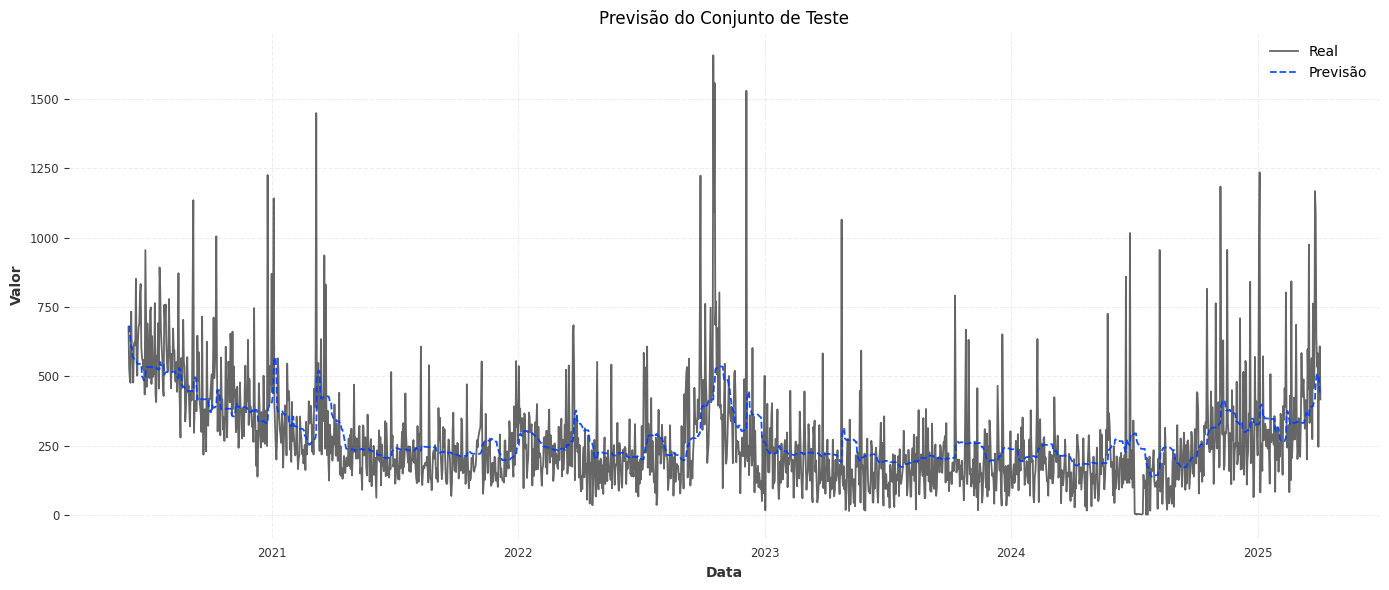

✅ MSE: 24382.4110 | MAE: 106.2343 | RMSE: 156.1487
✅ MAPE: 125.43% | R²: 0.3128


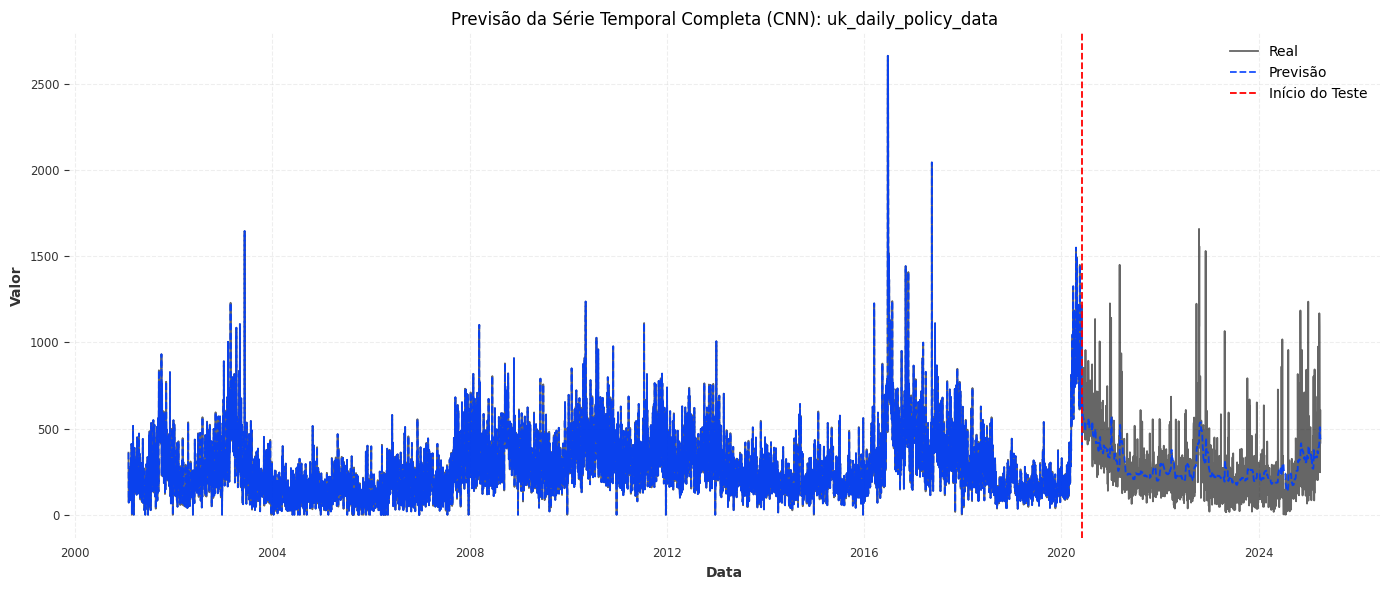

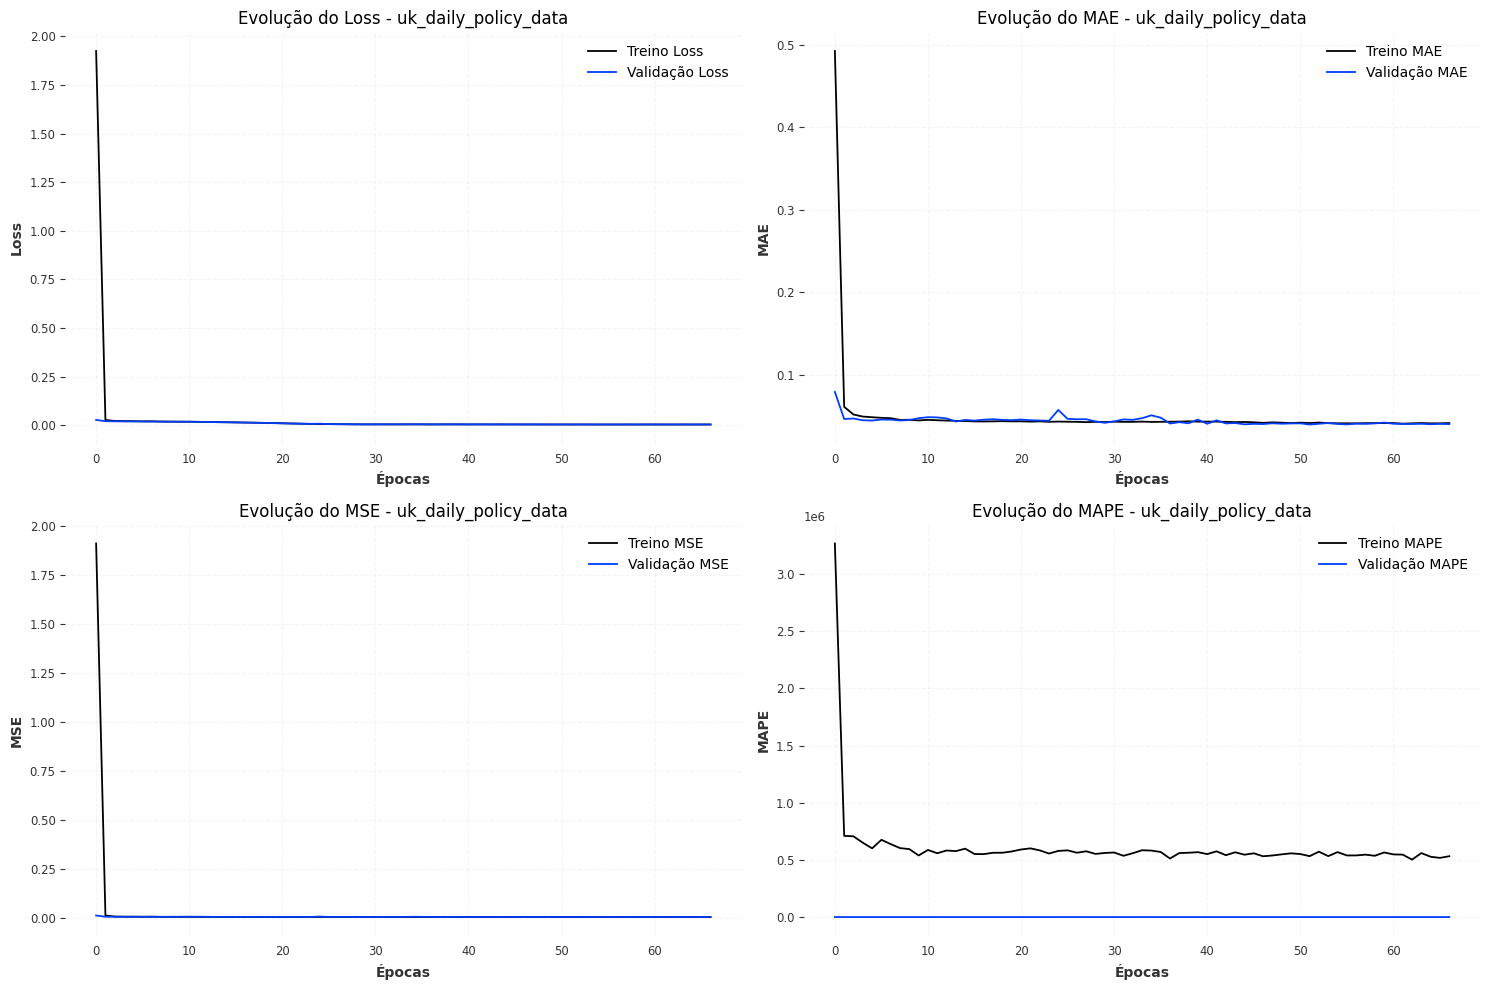

In [100]:
for idx, serie in enumerate(fred_series_list, 1):
    try:
        print(f"\n{'='*50}")
        print(f"🚀 Processando série {idx}/{len(fred_series_list)}: {serie.name}")
        
        # Rodar com parâmetros padrão
        model, history = treinar_para_serie(serie)
        
        # Opcional: Salvar o modelo se necessário
        # model.save(f'modelos/serie_{idx}.h5')
        
    except ValueError as ve:
        print(f"❌ Série {serie.name} ignorada - {str(ve)}")
    except Exception as e:
        print(f"❌ Erro inesperado na série {serie.name}: {str(e)}")
        continue  # Continua para a próxima série

In [101]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### PyTorch